# DCGAN
### This notebook contains an implementation of the model described [here](https://arxiv.org/abs/1511.06434)

In [1]:
from scripts import constants
constants = constants.get_constants()
# constants['scapes']['batch_size'] = 32
constants

{'len_seed': 100,
 'random_seed': 42,
 'mnist': {'width': 28,
  'height': 28,
  'color_mode': 'grayscale',
  'num_color_channels': 1,
  'batch_size': 100,
  'pixel_min': 0,
  'pixel_max': 255,
  'local': 'data/mnist',
  'colab': '/content/mnist'},
 'scapes': {'width': 1280,
  'height': 720,
  'color_mode': 'rgb',
  'num_color_channels': 3,
  'batch_size': 16,
  'pixel_min': 0,
  'pixel_max': 255,
  'local': 'data/scapes',
  'colab': '/content/scapes'}}

## Dataset

### Loading

In [2]:
from scripts.data.load import load_dataset

dataset_name = "scapes"

dataset = load_dataset(dataset_name, normalize=True, batch=True, colab=False)

Found 12000 files belonging to 1 classes.


### Training image preview

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

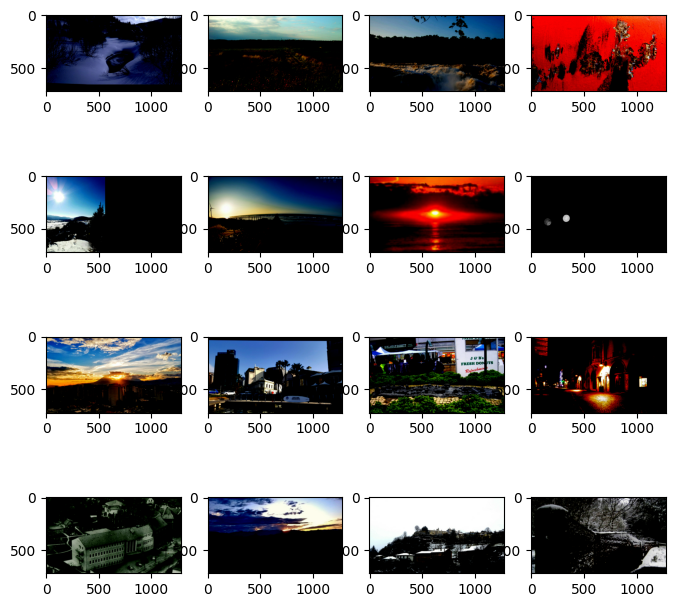

In [3]:
from scripts.data.visualization import display_images
import tensorflow as tf

# Take doesn't alter the dataset itself, so this won't affect the training
for batch in dataset.take(1):
    display_images(batch.numpy(), max_images=32)


## Build GAN

In [4]:
from scripts.model.build import build_dcgan, build_toy_model

generator, discriminator = build_dcgan(dataset_name)

{'num_hidden_conv_layers': 4, 'initial_width': 80, 'initial_height': 45, 'initial_num_filters': 2048}


/home/chen/big_bertha/coding/capstone/art-generator/env/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10800)             1090800   
                                                                 
 reshape (Reshape)           (None, 45, 80, 3)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 90, 160, 1024)    28672     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 90, 160, 1024)    4096      
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 180, 320, 512)    4719104   
 ranspose)                                                       
                                                        

## Test Generator output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.00010026773 0.002708253 -0.0031110025


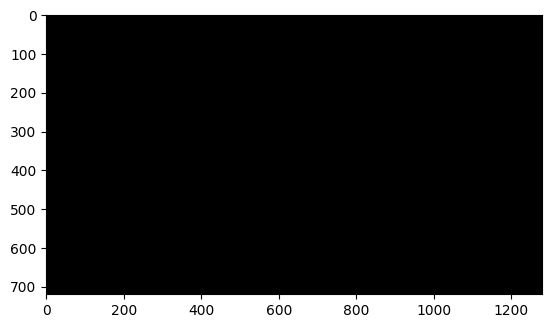

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

input_noise = tf.random.normal([1, 100])
generated_image = generator(input_noise, training=False)[0]
print(np.average(generated_image), np.max(generated_image), np.min(generated_image))
# generated_image[0]
plt.imshow(generated_image)

## Test Discriminator output

In [7]:
decision = discriminator(generated_image.reshape(
                                                    1, 
                                                    constants[dataset_name]['height'], 
                                                    constants[dataset_name]['width'], 
                                                    constants[dataset_name]['num_color_channels']
                                                )
                        )
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.000561]], dtype=float32)>

## Training the model

In [7]:
import time
from scripts.model.hyperparameters import get_dcgan_hyperparameters
from scripts.model.loss import generator_loss, discriminator_loss
from scripts.model.train import train

hyperparameters = get_dcgan_hyperparameters()

models = {
    'generator': {
        'model': generator,
        'loss': generator_loss,
        'optimizer': hyperparameters['optimizer']
    },
    'discriminator': {
        'model': discriminator,
        'loss': discriminator_loss,
        'optimizer': hyperparameters['optimizer']
    }
}

start = time.time()
train(models, dataset, epochs=1, len_seed=constants['len_seed'], num_test_seeds=16)
end = time.time()
print(f'Total training time (in seconds): {end - start}')

Loss for previous batch #0: Generator loss = None, Discriminator loss = None
Epoch # 1/1
Batch # 1


: 

: 

## Rescaling image output from [-1, 1] to [0, 255]

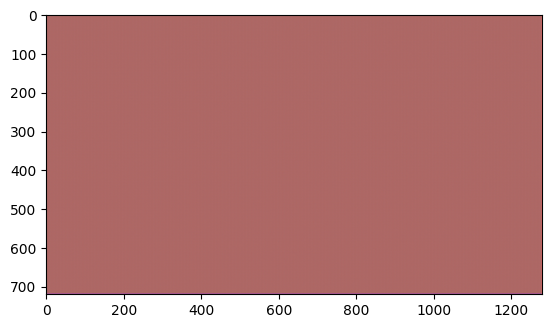

In [23]:
rand_seed = tf.random.normal([1, 100])
image = generator(rand_seed, training=False)[0]
image = image.numpy()
image = ((image - np.min(image)) * 255) / (np.max(image) - np.min(image))
# image
# image = ((image * 127.5) + 127.5)
image = image.astype(np.uint8)
plt.imshow(image)

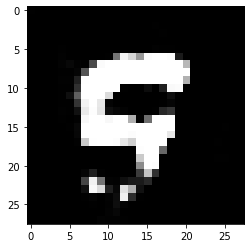

In [111]:
image = (image + 1)/(2) * 255
np.min(image), np.max(image)
# # image = np.expand_dims(image, axis=0)
# # rand_seed
plt.imshow(image[:, :, 0], cmap='gray')

## Saving the model

In [ ]:
generator.save('./models/generator')

In [ ]:
discriminator.save('./models/discriminator')

## Download folder

In [ ]:
!tar cvf toy_model_batch_processing.tgz toy_model_batch_processing/

In [ ]:
!tar cvf generator.tgz ./models/generator